In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

In [2]:
# Find dataset root
base_path = Path('../data/raw')

dataset_root = None
for path in [base_path / 'wearable-exam-stress-1.0.1', 
             base_path / 'physionet.org/files/wearable-exam-stress/1.0.1',
             base_path]:
    if path.exists() and (path / 'STRESS').exists():
        dataset_root = path
        break

if dataset_root is None:
    print("❌ Dataset not found!")
    print(f"Checked paths:")
    for path in [base_path / 'wearable-exam-stress-1.0.1', 
                 base_path / 'physionet.org/files/wearable-exam-stress/1.0.1',
                 base_path]:
        print(f"  - {path} (exists: {path.exists()})")
else:
    print(f"✅ Dataset root: {dataset_root}")
    
    # List what's inside
    print(f"\nContents:")
    for item in sorted(dataset_root.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")

✅ Dataset root: ../data/raw

Contents:
  📄 .DS_Store
  📁 AEROBIC/
  📁 ANAEROBIC/
  📁 STRESS/
  📄 Stress_Level_v1.csv
  📄 Stress_Level_v2.csv
  📄 data_constraints.txt
  📄 subject-info.csv


In [3]:
# Use a good quality subject (avoiding known issues)
sample_subject = 'S01'
stress_path = dataset_root / 'STRESS' / sample_subject

if not stress_path.exists():
    print(f"❌ {stress_path} not found!")
    print("\nAvailable subjects in STRESS:")
    stress_dir = dataset_root / 'STRESS'
    if stress_dir.exists():
        subjects = sorted([d.name for d in stress_dir.iterdir() if d.is_dir()])
        print(subjects)
        # Use first available subject
        if subjects:
            sample_subject = subjects[0]
            stress_path = dataset_root / 'STRESS' / sample_subject
            print(f"\n✅ Using {sample_subject} instead")
else:
    print(f"✅ Using subject: {sample_subject}")

print(f"\nFiles for {sample_subject}:")
if stress_path.exists():
    for file in sorted(stress_path.glob('*.csv')):
        size_kb = file.stat().st_size / 1024
        print(f"  - {file.name:<15} ({size_kb:>8.1f} KB)")

✅ Using subject: S01

Files for S01:
  - ACC.csv         (  1220.7 KB)
  - BVP.csv         (   999.2 KB)
  - EDA.csv         (    86.0 KB)
  - HR.csv          (    14.8 KB)
  - IBI.csv         (    17.5 KB)
  - TEMP.csv        (    60.6 KB)
  - tags.csv        (     0.3 KB)


In [5]:
# Check the actual format of BVP.csv
bvp_file = stress_path / 'BVP.csv'

if bvp_file.exists():
    print("📋 First 10 lines of BVP.csv:")
    print("="*60)
    with open(bvp_file, 'r') as f:
        for i, line in enumerate(f):
            if i < 10:
                print(f"Row {i}: {line.strip()}")
            else:
                break
    print("="*60)
else:
    print("❌ BVP.csv not found")

📋 First 10 lines of BVP.csv:
Row 0: 2013-02-20 17:55:19
Row 1: 64.0
Row 2: -0.0
Row 3: -0.0
Row 4: -0.0
Row 5: -0.0
Row 6: -0.0
Row 7: -0.0
Row 8: -0.0
Row 9: -0.0


In [7]:
# Read BVP (Blood Volume Pulse) with flexible parsing
bvp_file = stress_path / 'BVP.csv'

if not bvp_file.exists():
    print(f"❌ BVP.csv not found in {stress_path}")
else:
    # Read file
    bvp_df = pd.read_csv(bvp_file, header=None)
    
    # Try to parse metadata (first two rows)
    try:
        # Method 1: Unix timestamp in first row
        start_time_unix = float(bvp_df.iloc[0, 0])
        start_time = pd.to_datetime(start_time_unix, unit='s', utc=True)
        sample_rate = float(bvp_df.iloc[1, 0])
        bvp_values = bvp_df.iloc[2:, 0].astype(float).reset_index(drop=True)
        
    except ValueError:
        # Method 2: Datetime string in first row
        try:
            start_time = pd.to_datetime(bvp_df.iloc[0, 0])
            sample_rate = float(bvp_df.iloc[1, 0])
            bvp_values = bvp_df.iloc[2:, 0].astype(float).reset_index(drop=True)
        except:
            # Method 3: No header, all data
            print("⚠️  Non-standard format detected, treating all rows as data")
            start_time = pd.Timestamp.now(tz='UTC')
            sample_rate = 64.0  # Default BVP rate
            bvp_values = bvp_df.iloc[:, 0].astype(float).reset_index(drop=True)
    
    print(f"📊 BVP Signal Information:")
    print(f"   Start time: {start_time}")
    print(f"   Sample rate: {sample_rate} Hz")
    print(f"   Total samples: {len(bvp_values):,}")
    print(f"   Duration: {len(bvp_values) / sample_rate / 60:.2f} minutes")
    print(f"\n   First 10 values:")
    print(f"   {bvp_values.head(10).tolist()}")

📊 BVP Signal Information:
   Start time: 2013-02-20 17:55:19
   Sample rate: 64.0 Hz
   Total samples: 142,351
   Duration: 37.07 minutes

   First 10 values:
   [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]


/var/folders/g_/p2n0nvsd40bg2p_lbw5q92g40000gn/T/ipykernel_55748/287878336.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(


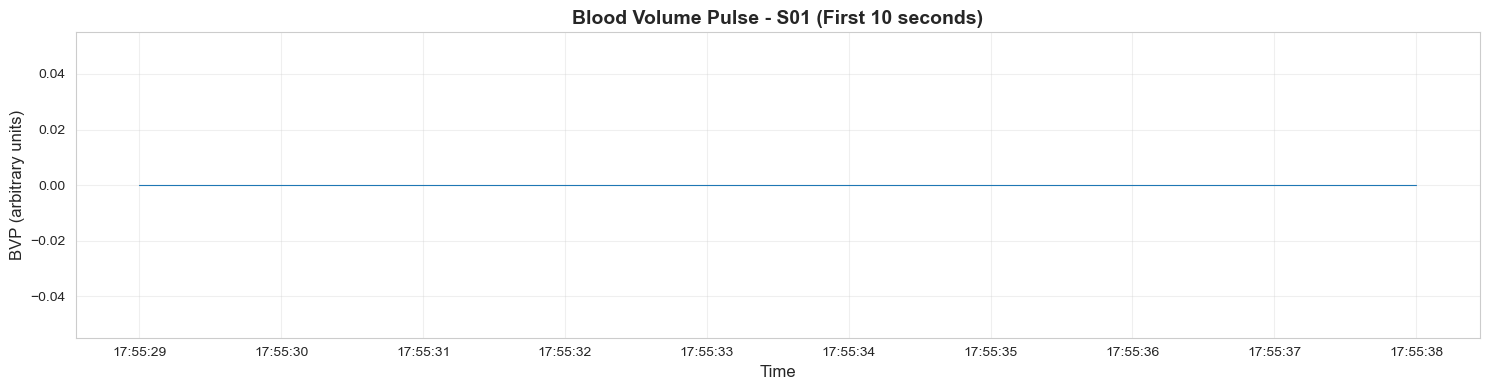

✅ Saved to diagrams/sample_bvp_signal.png


In [12]:
# Create timestamps for BVP data
timestamps = pd.date_range(
    start=start_time, 
    periods=len(bvp_values), 
    freq=f'{1/sample_rate}S'
)

# Plot first 10 seconds (640 samples at 64 Hz)
samples_10sec = min(int(10 * sample_rate), len(bvp_values))

plt.figure(figsize=(15, 4))
plt.plot(timestamps[:samples_10sec], bvp_values.iloc[:samples_10sec], linewidth=0.8)
plt.title(f'Blood Volume Pulse - {sample_subject} (First 10 seconds)', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('BVP (arbitrary units)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save diagram
diagrams_dir = Path('../diagrams')
diagrams_dir.mkdir(exist_ok=True)
plt.savefig(diagrams_dir / 'sample_bvp_signal.png', dpi=150, bbox_inches='tight')

plt.show()
print("✅ Saved to diagrams/sample_bvp_signal.png")

In [9]:
# Define signal files to load with expected sample rates
signal_files = {
    'BVP': {'file': 'BVP.csv', 'default_rate': 64.0},
    'EDA': {'file': 'EDA.csv', 'default_rate': 4.0},
    'TEMP': {'file': 'TEMP.csv', 'default_rate': 4.0},
    'HR': {'file': 'HR.csv', 'default_rate': 1.0}
}

# Store parsed data
signals_data = {}

for signal_name, config in signal_files.items():
    file_path = stress_path / config['file']
    
    if not file_path.exists():
        print(f"⚠️  {config['file']} not found, skipping...")
        continue
    
    try:
        # Parse file
        df = pd.read_csv(file_path, header=None)
        
        # Try different parsing methods
        try:
            # Method 1: Unix timestamp
            start_time_unix = float(df.iloc[0, 0])
            start_time = pd.to_datetime(start_time_unix, unit='s', utc=True)
            sample_rate = float(df.iloc[1, 0])
            values = df.iloc[2:, 0].astype(float).reset_index(drop=True)
        except ValueError:
            try:
                # Method 2: Datetime string
                start_time = pd.to_datetime(df.iloc[0, 0])
                sample_rate = float(df.iloc[1, 0])
                values = df.iloc[2:, 0].astype(float).reset_index(drop=True)
            except:
                # Method 3: All data, use defaults
                start_time = pd.Timestamp.now(tz='UTC')
                sample_rate = config['default_rate']
                values = df.iloc[:, 0].astype(float).reset_index(drop=True)
        
        # Create timestamps
        timestamps = pd.date_range(
            start=start_time, 
            periods=len(values), 
            freq=f'{1/sample_rate}S'
        )
        
        # Store
        signals_data[signal_name] = {
            'timestamps': timestamps,
            'values': values,
            'sample_rate': sample_rate,
            'start_time': start_time
        }
        
        print(f"✅ {signal_name}: {len(values):,} samples at {sample_rate} Hz")
        
    except Exception as e:
        print(f"❌ Error loading {signal_name}: {e}")

print(f"\n✅ Loaded {len(signals_data)} signals")

✅ BVP: 142,351 samples at 64.0 Hz
✅ EDA: 8,898 samples at 4.0 Hz
✅ TEMP: 8,896 samples at 4.0 Hz
✅ HR: 2,215 samples at 1.0 Hz

✅ Loaded 4 signals


/var/folders/g_/p2n0nvsd40bg2p_lbw5q92g40000gn/T/ipykernel_55748/1077192630.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/g_/p2n0nvsd40bg2p_lbw5q92g40000gn/T/ipykernel_55748/1077192630.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/g_/p2n0nvsd40bg2p_lbw5q92g40000gn/T/ipykernel_55748/1077192630.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(
/var/folders/g_/p2n0nvsd40bg2p_lbw5q92g40000gn/T/ipykernel_55748/1077192630.py:43: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(


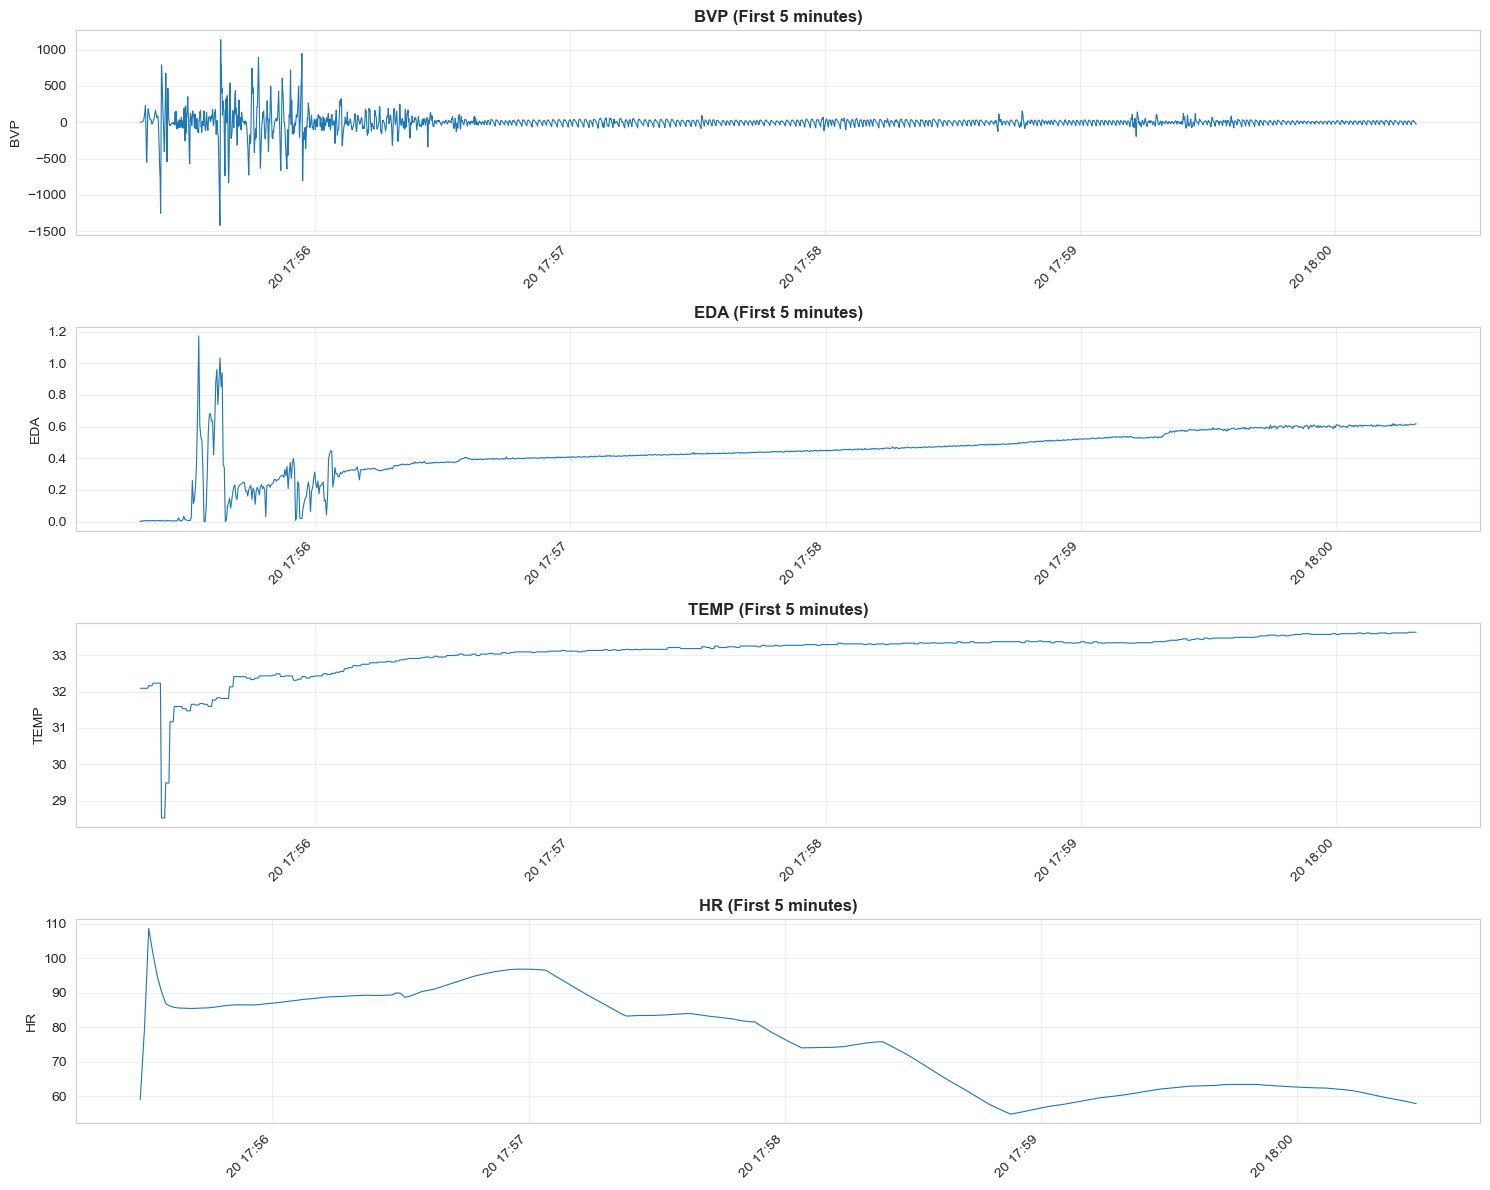

✅ Saved to diagrams/all_signals_overview.png


In [10]:
# Create multi-panel plot
n_signals = len(signals_data)

if n_signals == 0:
    print("❌ No signals loaded to plot")
else:
    fig, axes = plt.subplots(n_signals, 1, figsize=(15, 3*n_signals))
    
    # Handle case of single signal
    if n_signals == 1:
        axes = [axes]
    
    for idx, (signal_name, data) in enumerate(signals_data.items()):
        timestamps = data['timestamps']
        values = data['values']
        sample_rate = data['sample_rate']
        
        # Plot first 5 minutes
        samples_5min = int(min(5 * 60 * sample_rate, len(values)))
        
        axes[idx].plot(timestamps[:samples_5min], values.iloc[:samples_5min], linewidth=0.8)
        axes[idx].set_title(f'{signal_name} (First 5 minutes)', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(signal_name, fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for readability
        for label in axes[idx].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    
    plt.tight_layout()
    plt.savefig(diagrams_dir / 'all_signals_overview.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Saved to diagrams/all_signals_overview.png")

In [14]:
# Load protocol event markers
tags_file = stress_path / 'tags.csv'

if not tags_file.exists():
    print("⚠️  No tags.csv file found")
else:
    try:
        tags_df = pd.read_csv(tags_file, header=None)
        tags_df.columns = ['timestamp_unix']
        
        # Try to parse timestamps
        try:
            # Try as Unix timestamp
            tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp_unix'], unit='s', utc=True)
        except:
            # Try as datetime string
            tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp_unix'])
        
        # Calculate time from start of session
        session_start = tags_df['timestamp'].min()
        tags_df['seconds_from_start'] = (tags_df['timestamp'] - session_start).dt.total_seconds()
        tags_df['minutes_from_start'] = tags_df['seconds_from_start'] / 60
        tags_df['event_number'] = range(1, len(tags_df) + 1)
        
        print("Protocol Event Markers:")
        print(tags_df[['event_number', 'minutes_from_start', 'timestamp']].to_string(index=False))
        
        print(f"\n Interpretation:")
        print(f"   These markers indicate when the experimenter pressed the button")
        print(f"   Typically marks: baseline → test1 → rest → test2 → rest → test3")
        
    except Exception as e:
        print(f"❌ Error parsing tags: {e}")

Protocol Event Markers:
 event_number  minutes_from_start           timestamp
            1            0.000000 2013-02-20 18:01:30
            2            4.116667 2013-02-20 18:05:37
            3            7.033333 2013-02-20 18:08:32
            4            8.783333 2013-02-20 18:10:17
            5           16.116667 2013-02-20 18:17:37
            6           18.200000 2013-02-20 18:19:42
            7           23.316667 2013-02-20 18:24:49
            8           23.783333 2013-02-20 18:25:17
            9           24.416667 2013-02-20 18:25:55
           10           25.033333 2013-02-20 18:26:32
           11           25.733333 2013-02-20 18:27:14
           12           26.266667 2013-02-20 18:27:46
           13           26.516667 2013-02-20 18:28:01

 Interpretation:
   These markers indicate when the experimenter pressed the button
   Typically marks: baseline → test1 → rest → test2 → rest → test3


In [16]:
# Calculate summary statistics for all signals
summary_data = []

for signal_name, data in signals_data.items():
    values = data['values']
    sample_rate = data['sample_rate']
    
    summary_data.append({
        'Signal': signal_name,
        'Sample Rate (Hz)': sample_rate,
        'Total Samples': f"{len(values):,}",
        'Duration (min)': f"{len(values) / sample_rate / 60:.2f}",
        'Mean': f"{values.mean():.2f}",
        'Std Dev': f"{values.std():.2f}",
        'Min': f"{values.min():.2f}",
        'Max': f"{values.max():.2f}"
    })

summary_df = pd.DataFrame(summary_data)

print("Signal Summary Statistics:")
print("="*80)
print(summary_df.to_string(index=False))

Signal Summary Statistics:
Signal  Sample Rate (Hz) Total Samples Duration (min)  Mean Std Dev      Min     Max
   BVP              64.0       142,351          37.07  0.00   59.58 -1418.36 1134.52
   EDA               4.0         8,898          37.08  0.64    0.14     0.00    1.58
  TEMP               4.0         8,896          37.07 33.43    0.44    28.53   33.95
    HR               1.0         2,215          36.92 64.52   10.73    49.37  108.67


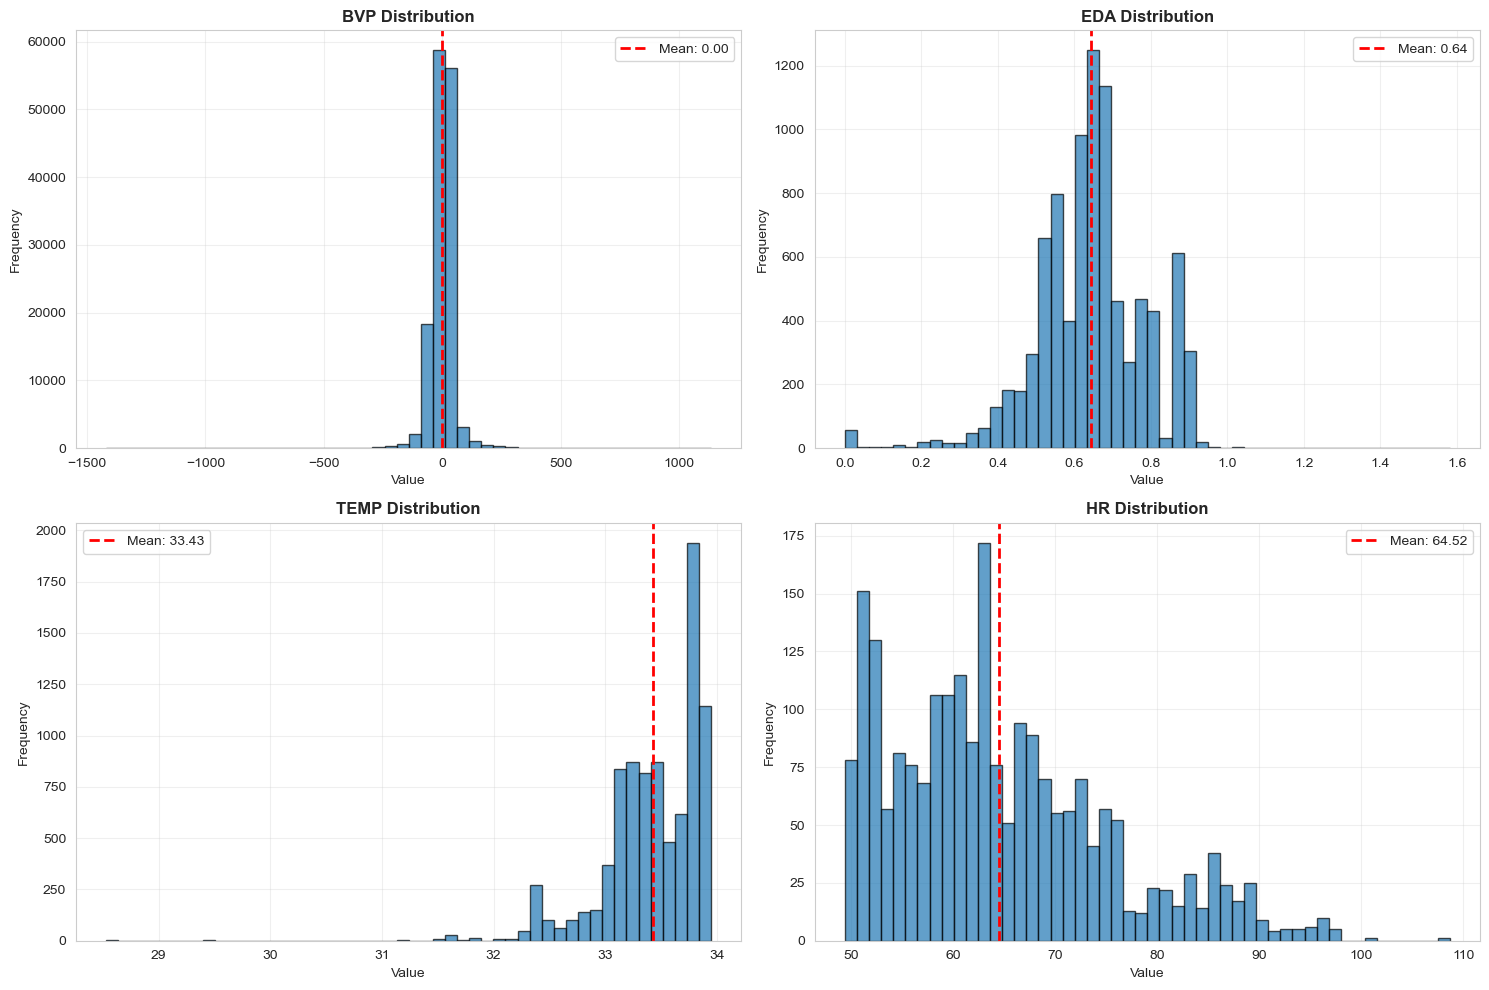

✅ Saved to diagrams/signal_distributions.png


In [17]:
# Plot distributions
n_signals = len(signals_data)

if n_signals == 0:
    print("❌ No signals to plot")
else:
    # Determine grid size
    n_cols = 2
    n_rows = (n_signals + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Flatten axes for easier indexing
    if n_signals == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (signal_name, data) in enumerate(signals_data.items()):
        values = data['values']
        
        axes[idx].hist(values, bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{signal_name} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        
        # Add mean line
        mean_val = values.mean()
        axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].legend()
    
    # Hide unused subplots
    for idx in range(n_signals, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(diagrams_dir / 'signal_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Saved to diagrams/signal_distributions.png")